# Horizontal Integration Tutorial for SM Data

This tutorial demonstrates the process of horizontally integrating spatial metabolomics (SM) data using spatialMETA. Horizontal integration is a powerful technique to address batch effects.

In [2]:
import spatialmeta as smt
from spatialmeta.model import AlignmentVAE
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import copy
import matplotlib.pyplot as plt

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
RCC_sample_list = ["R114_T","S15_T","X49_T","Y27_T","Y7_T"]

## Read and proprocess data

### Read and merge data

In this step, we read and merge the SM data for each sample.

In [15]:
for i in RCC_sample_list:
    adata_SM = sc.read_h5ad("./spatialmeta_tutorial/data/ccRCC_samples/adata_SM_"+i+"_raw.h5ad")
    adata_name = "adata_SM_"+i
    globals()[adata_name] = adata_SM

In [16]:
merge_SM_adata = anndata.concat({
"R114_T":adata_SM_R114_T,
"S15_T":adata_SM_S15_T,
"X49_T":adata_SM_X49_T,
"Y27_T":adata_SM_Y27_T,
"Y7_T":adata_SM_Y7_T,
},label="sample")

/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [17]:
merge_SM_adata.write_h5ad("./spatialmeta_tutorial/data/ccRCC_merge_SM.h5ad")

### Normalize merge data

In this step, we normalize the merged data.

In [18]:
merge_SM_adata.layers["counts"] = merge_SM_adata.X.copy()

In [19]:
sc.pp.normalize_total(
    merge_SM_adata,
    target_sum = 1e4
)

In [20]:
merge_SM_adata.layers["normalized"] = merge_SM_adata.X.copy()

### Calculate SVMs and remove batch-baised SVMs

We also calculate spatial bariable metabolites(SVMs) to identify features that exhibit spatial variation. In addition, we remove those that are batch-biased.

In [21]:
smt.pp.spatial_variable(merge_SM_adata,
                        n_top_variable=800,
                        add_key = "highly_variable_moranI",
                        batch_key="sample",
                        min_samples = 3,
                        min_frac = 0.9,
                        min_logfc= 3
                       )

In [22]:
merge_SM_adata = merge_SM_adata[:,merge_SM_adata.var.highly_variable_moranI]

In [23]:
merge_SM_adata

View of AnnData object with n_obs × n_vars = 72336 × 697
    obs: 'x_coord_original', 'y_coord_original', 'total_intensity_pos', 'mean_intensity_pos', 'total_intensity_neg', 'mean_intensity_neg', 'spot_index', 'total_intensity', 'mean_intensity', 'sample'
    var: 'highly_variable_moranI'
    uns: 'rank_genes_groups'
    obsm: 'spatial', 'spatial_normalized', 'spatial_transformed', 'spatial_transformed_scaled'
    layers: 'counts', 'normalized'

In [24]:
merge_SM_adata.write_h5ad("./spatialmeta_tutorial/data/ccRCC_merge_SM_hvm.h5ad")

## ConditionalVAESM for horizontal integration for SM¶

In this step, we perform horizontal integration using the ConditionalVAESM model.

In [25]:
merge_SM_adata.X = merge_SM_adata.layers['normalized']

In [26]:
merge_SM_adata.var['type'] = "SM"

/tmp/ipykernel_38705/2257733875.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  merge_SM_adata.var['type'] = "SM"
/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [27]:
model = smt.model.ConditionalVAESM(merge_SM_adata,
                                       n_latent=10,
                                       device='cuda:0',
                                       batch_keys="sample",
                                       batch_embedding="embedding"
                                      )

In [28]:
loss_dict = model.fit(
    max_epoch=64, 
    lr=1e-3,
    kl_loss_reduction= 'mean',
    kl_weight = 15,
    n_epochs_kl_warmup = 0
)

/home/rolan/Documents/spatialMETA/spatialmeta/util/logger.py:151: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm as tqdm_notebook
Epoch 64: 100%|██████████| 64/64 [02:15<00:00,  2.12s/it, reconst=4.33e+03, kldiv=5.57e+02, total_loss=4.89e+03]     


### Visualization and analysis

In [32]:
Z = model.get_latent_embedding()
X = model.get_normalized_expression()

Latent Embedding: 100%|██████████| 566/566 [00:01<00:00, 511.62it/s]                                                 


In [33]:
merge_SM_adata.layers['reconstruction'] = X
merge_SM_adata.obsm['X_emb']=Z

In [9]:
sc.pp.neighbors(merge_SM_adata,use_rep="X_emb",n_neighbors=15)
sc.tl.umap(merge_SM_adata,
          min_dist=1,spread=1)
sc.tl.leiden(merge_SM_adata, 
             key_added="VAE_clusters_latent10")

<Axes: title={'center': 'sample'}, xlabel='UMAP1', ylabel='UMAP2'>

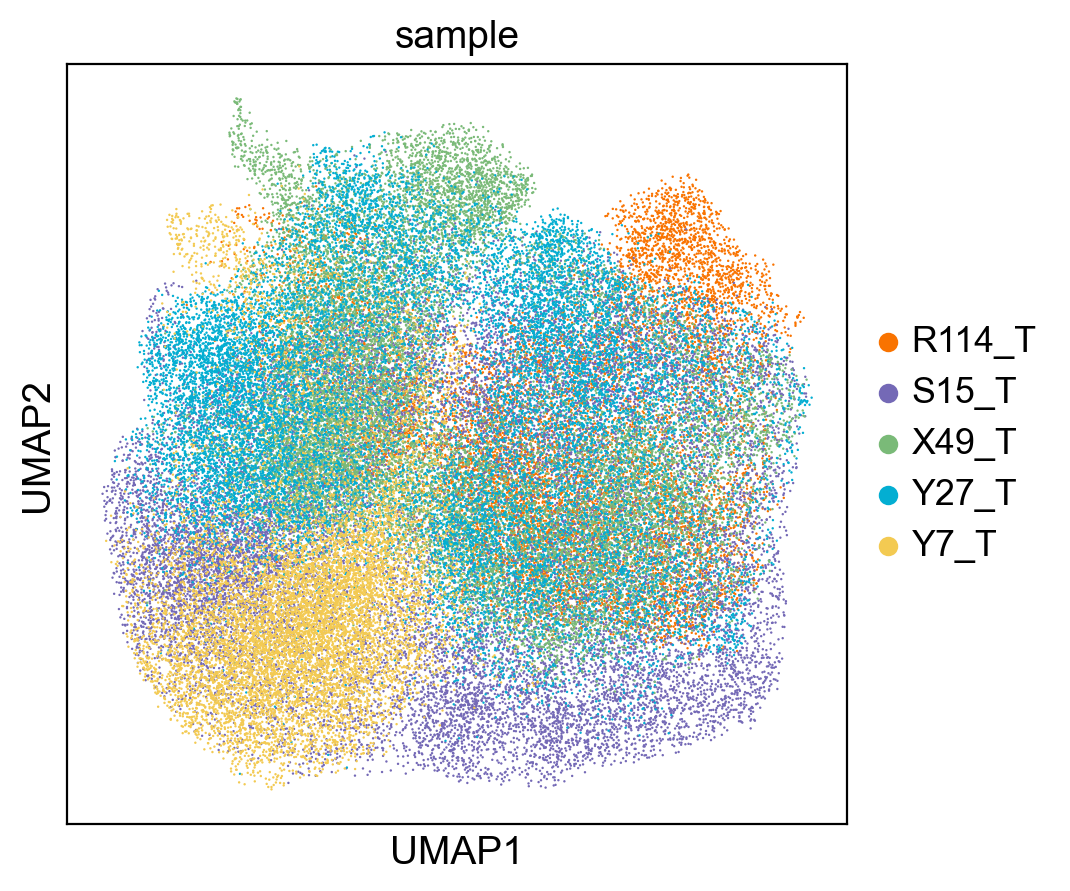

In [11]:
sc.settings.set_figure_params(dpi=100, facecolor="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,5)
sc.pl.umap(merge_SM_adata,color=["sample"],
          palette = {
              "R114_T": "#F97300",
              "S15_T": "#7469B6",
              "X49_T": "#7ABA78",
              "Y27_T": "#03AED2",
              "Y7_T": "#F3CA52",
          },
          show = False,
          size = 3,
          ax=ax)

<Axes: title={'center': 'joint_clusters'}, xlabel='UMAP1', ylabel='UMAP2'>

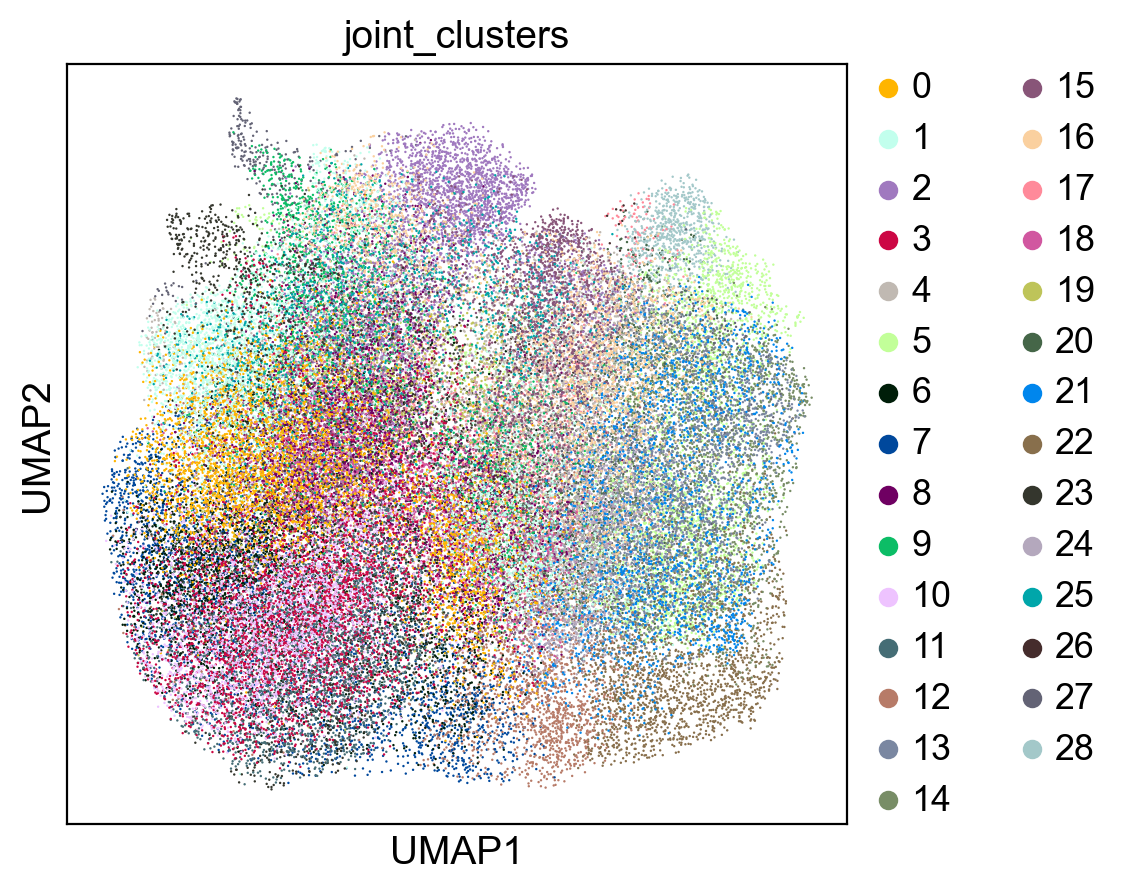

In [12]:
sc.settings.set_figure_params(dpi=100, facecolor="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,5)
sc.pl.umap(merge_SM_adata,color=["joint_clusters"],
          palette = sc.pl.palettes.godsnot_102[40:],
          show = False,
          size = 3,
          ax=ax)

In [38]:
merge_SM_adata.write_h5ad("./spatialmeta_tutorial/data/ccRCC_merge_SM_hvm_afterVAE.h5ad")